# Demonstration Notebook

This notebook goes through and demonstrates some of the features of the code as it currently stands.

In [1]:
import pyNab as Nab

C:\Users\divad\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


Due to some ongoing work on experimental GPU features, some warning statments may print during import
If you see statements about CUDA or cupy, they should be safe to ignore
If you have any questions feel free to email me: dgma224@g.uky.edu


## Opening the data files

First we need to go through and open up the various datafiles with the class. 
As we will want to cut on pixels, it's best if we go through and pass a pixel mapping to the code so 
first let's open up a pixel map file and parse that.

In [2]:
pixelMap = Nab.np.loadtxt('C:\\Users\\divad\\Downloads\\PixelFetPreampMapManitoba6-16-2021.csv', skiprows=1, dtype=str, delimiter=',')
removedEmptyBoards = []
for row in pixelMap:
	if row[-1] != '':
		removedEmptyBoards.append(list(row))
removedEmptyBoards = Nab.np.array(removedEmptyBoards)
pixels = removedEmptyBoards[:,0]

What that function did was open up the file, remove any rows from the file that had an empty board entry (because some of them do), and then it goes and grabs only the pixels from the remaining table. The code expects to see an array where each element is the pixel number. For example: array[0] = 1 would mean that pixel 1 is on DAQ board 0 channel 0. array[10] = 64 would mean that pixel 64 is on DAQ board 1 channel 2.

Now we need to pass this array, along with a file location (or a list of file locations) to the class to open up a waveform file.

In [3]:
fileDirectory = 'C:\\Users\\divad\\OneDrive\\Documents\\datafiles\\Cd109MultipleBiases\\Bias50V\\'
filenames = []
filenames.append(fileDirectory + 'ScopeRun420_0.scope')

waveformFile = Nab.wf.waveformFile(filenames, pixelMapping=pixels)

That opened up the file and applied the pixel map to the file. Now let's see what type of data we have.

Here are a few functions you can use to access information about the file.

In [4]:
boards, mapping, numberOfHits = waveformFile.bcs #this tells you how many hits you had per board channel
print('board channel hit information: ', boards, numberOfHits)

numwaves = waveformFile.numWaves #this tells you how many waveforms there are total
print('number of waveforms: ', numwaves)

board channel hit information:  [17, 19, 20, 21] [63828 51625 25478 43696]
number of waveforms:  184627


If you want to look at a particular waveform, you can simply do this

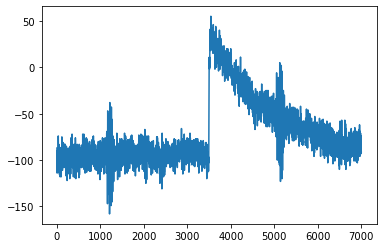

In [5]:
waveform = waveformFile.wave(2)
Nab.plt.plot(waveform)
Nab.plt.show()

If you want to access every waveform and header, you can do this. Note that I don't really recommend you do this to retrieve all of the waveforms as this will eat up RAM rather rapidly. It's okay for the headers, but for waveforms it's recommended you do individual calls to the .wave() function. Note that waveforms returned in this manner still need to be converted from 14-bit to 16-bit as defined in the Nab.bf.wavePrep() function.

When you call this function this time, it will run very rapidly. That is because I deliberately left off the .compute() addition that tells the code to load everything from the files into memory. Again I don't really recommend you use this unless you know what you're doing.

In [6]:
waveforms = waveformFile.waves()
headers = waveformFile.headers()

Now let's do some analysis. Let's say you want to get an energy histogram from pixel 76, or bc 17 but you aren't sure how to call the function. Run this script to see how to call any of the functions in the code. Note that not all are documented nicely yet but I'm working on it.

In [7]:
waveformFile.determineEnergyTiming?

We can run this analysis in two ways. 

First: We can run it over everything and then cut on the results to just look at the pixel we want.
Second: We can just run it over the pixel we want if we cut on the waveformFile. 

Let's do both ways.

First method first.

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:26<00:00,  9.56s/it]


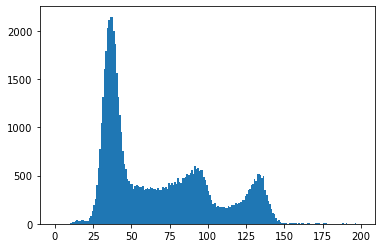

In [8]:
overallResults = waveformFile.determineEnergyTiming(method='trap', params=[1250, 50, 1250], batchsize=20000)
overallResults.defineCut('bc', '=', 17)
#or the same thing
overallResults.defineCut('pixel', '=', 76)
#now plot the energies
overallResults.hist('energy', bins = Nab.np.arange(0, 200))
overallResults.show()

Second Method: Cut on the waveform file and only run over the board we care about.
This is a lot faster.

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.74s/it]


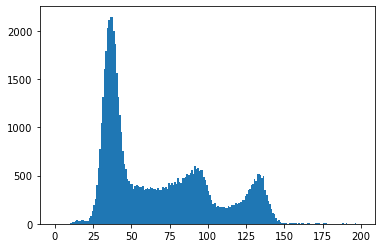

In [9]:
waveformFile.defineCut('bc', '=', 17)
waveformFile.defineCut('pixel', '=', 76) #again both options work, just showing both for demonstration purposes
onlyPixel76Results = waveformFile.determineEnergyTiming(method='trap', params=[1250, 50, 1250], batchsize=20000)
onlyPixel76Results.hist('energy', bins = Nab.np.arange(0, 200))
onlyPixel76Results.show()

Want to see something weird? Go back and re-run the code block for the first method. You'll notice it's suddenly a lot faster. 

Why is that? Because you defined a cut on the same waveformFile object. It's only looking at a subset of the data now. 
If you want to reset your cuts, you need to call this function. 

In [10]:
waveformFile.resetCuts()
overallResults.resetCuts()

There are a lot of other cut possibilities. The full list is described below

In [18]:
waveformFile.defineCut?

To check what categories you can cut on, you can just call this function

In [12]:
print(waveformFile.names)
print(overallResults.names)

['result', 'eventid', 'bc', 'timestamp', 'req', 'source', 'length', 'board', 'channel', 'pixel']
['result' 'eventid' 'bc' 'timestamp' 'req' 'source' 'length' 'board'
 'channel' 'pixel' 'energy' 't0']


With all of that taken care of now, let's do a quick fit of some data.

In [13]:
waveformFile.resetCuts()
waveformFile.defineCut('pixel', '=', 76)
results = waveformFile.determineEnergyTiming(method='trap', params=[1250, 50, 1250], batchsize=20000)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.73s/it]


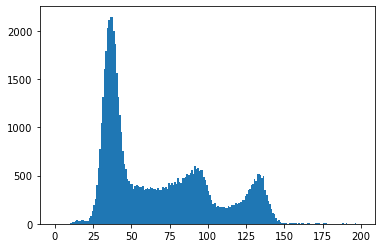

In [14]:
results.hist('energy', bins=Nab.np.arange(0, 200))
results.show()

It looks like there is a peak between 125 and 150 so let's fit that to a gaussian (the only function supported currently).

Note that I change the bins when I call fitHist. This means the fit function will only consider the data in that particular region instead of the whole histogram.

p0 is an initial guess at the best fit parameters. It isn't required, but highly recommended for reliable fits. 

The order of parameters is as follows: p0=[amplitude, mean, sigma, offset from 0]

color='orange' of course sets the color.

rounding = 2 means it will round the fitted values to 2 decimal places when plotting them. It doesnt, or shouldn't, affect the returned values

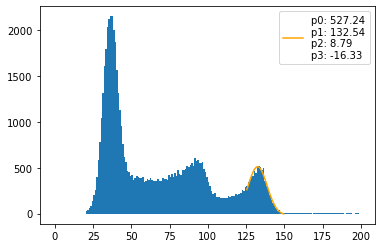

In [15]:
results.resetCuts()
results.defineCut('energy', '>', 20)
results.hist('energy', bins = Nab.np.arange(0, 200))
parameters, errors = results.fitHist('energy', bins = Nab.np.arange(125, 150), p0=[500, 130, 10, 0], color='orange', rounding = 2) 
results.legend()
results.show() #technically this isn't needed but I do it out of habit

Now we have gone through and fit a histogram with the code and discussed some basic cutting techniques. Now let's say that you want to look at only waveforms that occur in a particular energy range. Well that's actually pretty easy to do.

The code below only will average waveforms from pixel 76 in the peak we just fit. I have it start from scratch to show the whole process, not because it was required. I also have it correct the baseline offset by shifting the initial part of the waveform, as defined by the pretrigger, such that it has a mean value of 0. This corrects for any changes in the offset.

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.87s/it]


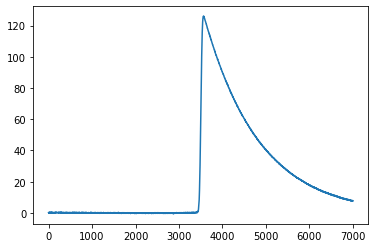

In [16]:
waveformFile.resetCuts()
waveformFile.defineCut('pixel', '=', 76)
results = waveformFile.determineEnergyTiming(method='trap', params=[1250, 50, 1250], batchsize=20000)
results.defineCut('energy', 'between', 125, 150)
cut = results.returnCut()
waveformFile.defineCut('custom', cut)
averageWaveform = waveformFile.averageWaveforms(correctBaseline=True)
Nab.plt.plot(averageWaveform)
Nab.plt.show()

'custom' cuts can be very powerful tools but also are risky. They are meant to be used as I show here where you make a resultFile from some dataset, then go through and apply some cuts based on the extracted energies and waveform start times. You can of course write your own exotic cutting function and apply it to the data, but do so at your own risk.

To return the results as a Pandas DataFrame, simply call this function. The added .compute() operation changes the return from a Dask DataFrame to a Pandas DataFrame (almost the same thing but there are some differences). You'll notice that some indices are missing, either from the cuts we applied to the results, or from being calculated from only a subset of the original data. This is important to know about if you are doing your own custom cutting functions.

In [17]:
results.data().compute()

,result,eventid,bc,timestamp,req,source,length,board,channel,pixel,energy,t0
39,1,39,17,702224264,702309558,0,7000,2,1,76,138.387352,3469.0
60,1,60,17,1110739310,1110889580,0,7000,2,1,76,132.766898,3509.5
65,1,65,17,1179189676,1179286292,0,7000,2,1,76,137.389479,3523.0
107,1,107,17,2045433854,2045588012,0,7000,2,1,76,131.913898,3492.5
161,1,161,17,2946282990,2946446144,0,7000,2,1,76,129.926797,3512.5
...,...,...,...,...,...,...,...,...,...,...,...,...
184510,1,184510,17,3802234728768,3802234890974,0,7000,2,1,76,127.802386,3508.5
184533,1,184533,17,3802771739412,3802771827268,0,7000,2,1,76,126.750710,3517.5
184539,1,184539,17,3802839583468,3802839709992,0,7000,2,1,76,131.116958,3503.5
184561,1,184561,17,3803451726762,3803451848084,0,7000,2,1,76,129.642543,3476.5


Well I think that is basically everything you need to know about the code for most analysis processes. Feel free to ask me anything via email or slack about the code. If there are any functions you want added, let me know and I'll see what I can do!